In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math

In [7]:
filename = "ASTR19_F25_group_project_data.txt"

raw_data = []

with open(filename, "r") as f:
    for line in f:
        line = line.strip()

        # Skip empty or commented lines
        if not line or line.startswith("#"):
            continue

        parts = line.split()
        day = int(parts[0])
        time_str = parts[1]
        height = float(parts[2])

        raw_data.append((day, time_str, height))

print(f"Loaded {len(raw_data)} measurements.")




Loaded 82 measurements.


In [8]:
t_list = []
h_list = []

for day, tstr, height in raw_data:
    hh, mm = map(int, tstr.split(":"))
    frac_day = (day - 1) + (hh + mm/60)/24.0

    t_list.append(frac_day)
    h_list.append(height)

t = np.array(t_list)
y = np.array(h_list)


In [9]:
order = np.argsort(t)
t = t[order]
y = y[order]


In [10]:
P1 = 12.42 / 24.0
P2 = 24.0 / 24.0

def tide_model(t, mean, A1, phi1, A2, phi2):
    return (mean
            + A1 * np.sin(2*np.pi*t/P1 + phi1)
            + A2 * np.sin(2*np.pi*t/P2 + phi2))


In [11]:
sigma = np.full_like(y, 0.25)

mean0 = np.mean(y)
A0 = 0.5*(np.max(y)-np.min(y))

p0 = [mean0, 0.8*A0, 0.0, 0.3*A0, 0.0]

popt, pcov = curve_fit(
    tide_model, t, y, p0=p0, sigma=sigma, absolute_sigma=True
)

perr = np.sqrt(np.diag(pcov))

popt, perr


(array([ 2.52378663, -1.0194096 , -1.02363984,  2.6761474 , -0.27512788]),
 array([0.03229893, 0.11600279, 0.07481155, 0.07865025, 0.02556175]))

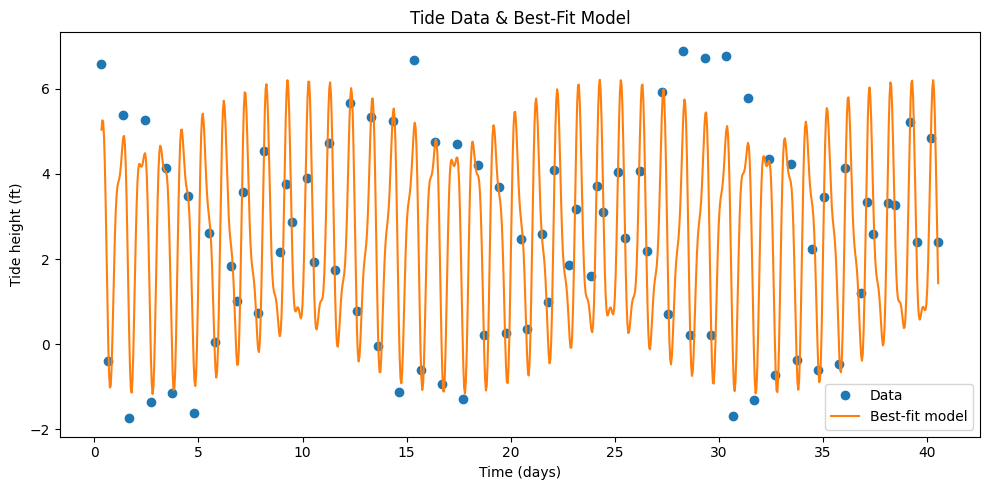

In [12]:
t_dense = np.linspace(t.min(), t.max(), 1000)
y_fit = tide_model(t_dense, *popt)

plt.figure(figsize=(10,5))
plt.plot(t, y, 'o', label="Data")
plt.plot(t_dense, y_fit, '-', label="Best-fit model")

plt.xlabel("Time (days)")
plt.ylabel("Tide height (ft)")
plt.title("Tide Data & Best-Fit Model")
plt.legend()
plt.tight_layout()

plt.savefig("tide_model_vs_data.pdf")
plt.show()


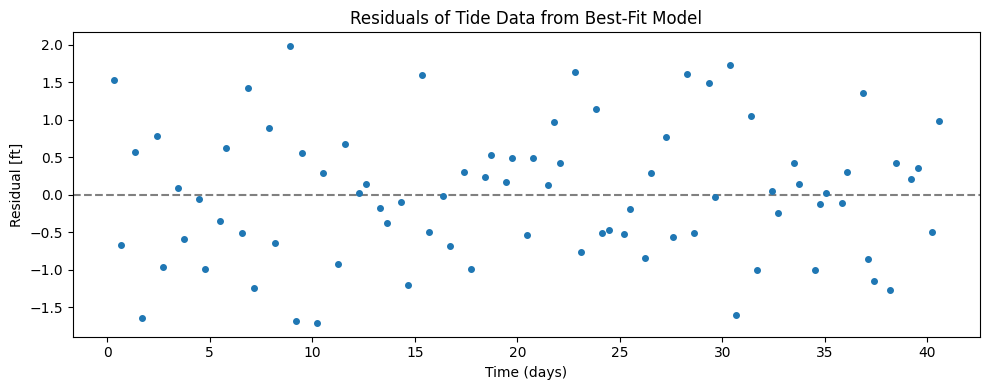

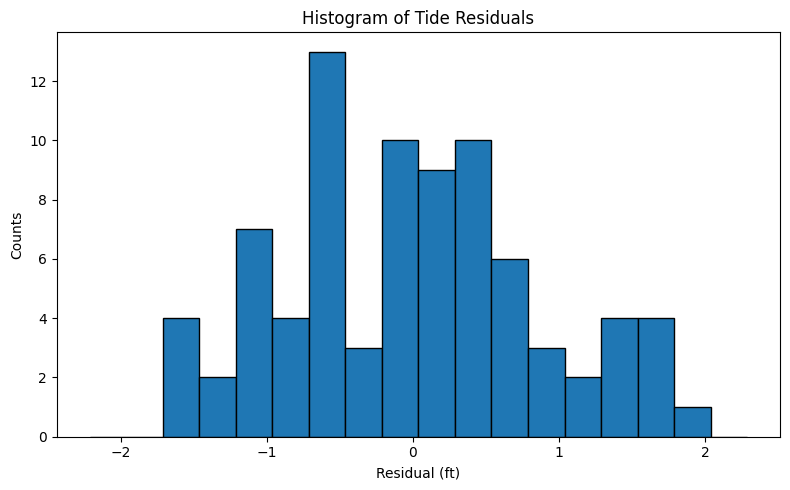

Standard deviation of residuals: 0.8766179379041962
Estimated intrinsic scatter: 0.8402136686911282


In [20]:

residuals = y - tide_model(t, *popt)


plt.figure(figsize=(10,4))
plt.axhline(0, color='gray', linestyle='--')
plt.plot(t, residuals, 'o', markersize=4)

plt.xlabel("Time (days)")
plt.ylabel("Residual [ft]")
plt.title("Residuals of Tide Data from Best-Fit Model")
plt.tight_layout()
plt.savefig("tide_residuals.pdf")
plt.show()


plt.figure(figsize=(8,5))


bin_width = 0.25
bins = np.arange(residuals.min()-0.5, residuals.max()+0.5, bin_width)

plt.hist(residuals, bins=bins, edgecolor='black')

plt.xlabel("Residual (ft)")
plt.ylabel("Counts")
plt.title("Histogram of Tide Residuals")
plt.tight_layout()
plt.savefig("tide_residual_histogram.pdf")
plt.show()


std_resid = np.std(residuals, ddof=1)
print("Standard deviation of residuals:", std_resid)


measurement_err = 0.25  # ft
intrinsic_scatter = np.sqrt(max(0, std_resid**2 - measurement_err**2))
print("Estimated intrinsic scatter:", intrinsic_scatter)



Tsunami deviation in units of σ: 2.28 sigma


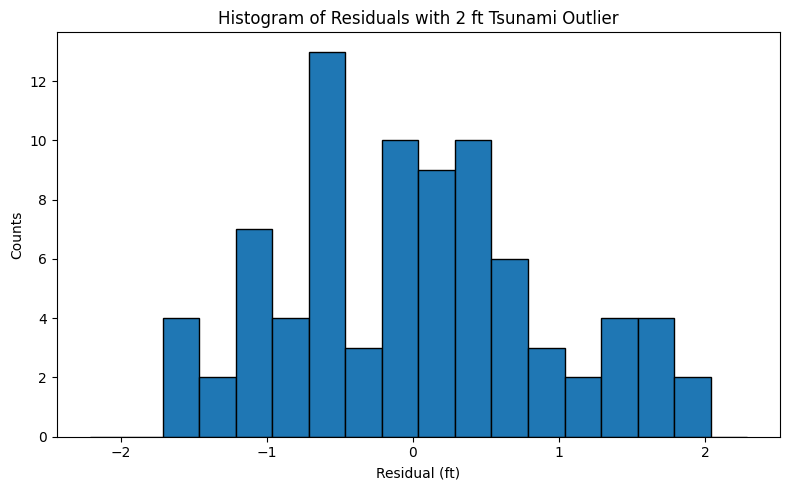

In [21]:
# --- 4) Tsunami deviation ---

tsunami_value = 2.0  # ft deviation

# How many sigma is this?
sigma_units = tsunami_value / std_resid
print(f"Tsunami deviation in units of σ: {sigma_units:.2f} sigma")

# Add the outlier to residual array
residuals_with_outlier = np.append(residuals, tsunami_value)

# --- Replot histogram including outlier ---
plt.figure(figsize=(8,5))

# Same bin width for consistency
bins = np.arange(residuals_with_outlier.min()-0.5,
                 residuals_with_outlier.max()+0.5,
                 bin_width)

plt.hist(residuals_with_outlier, bins=bins, edgecolor="black")

plt.xlabel("Residual (ft)")
plt.ylabel("Counts")
plt.title("Histogram of Residuals with 2 ft Tsunami Outlier")
plt.tight_layout()

plt.savefig("tide_residual_histogram_with_outlier.pdf")
plt.show()